In [1]:
# --- Import Necessary Libraries ---

# For data manipulation
import pandas as pd
import re

# For sentiment analysis model
from transformers import pipeline

# For keyword extraction (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')

print("All libraries imported successfully.")

C:\Users\Admin\anaconda3\envs\review-radar-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully.


In [2]:
# Define the list of file paths for your CSVs
file_paths = ['ball_test.csv', 'bracelet_test.csv', 'lens_test.csv', 'fan_test.csv', 'coffee_test.csv', 'ps4_controller_test.csv'] # <--- ADD YOUR FILENAMES HERE

# Create an empty list to hold the individual DataFrames
list_of_dfs = []

print(f"Attempting to load {len(file_paths)} CSV files...")

# Loop through the list of file paths
for file_path in file_paths:
    try:
        # Load the CSV into a pandas DataFrame
        temp_df = pd.read_csv(file_path)
        
        # --- IMPORTANT: Ensure the column name is consistent ---
        # If your review column has different names in different files, rename them here.
        # For example, if some files have 'review' and others have 'review_text':
        # if 'review' in temp_df.columns:
        #     temp_df = temp_df.rename(columns={'review': 'review_text'})
        
        list_of_dfs.append(temp_df)
        print(f"  - Successfully loaded '{file_path}' ({len(temp_df)} rows)")
        
    except FileNotFoundError:
        print(f"  - Error: The file '{file_path}' was not found. It will be skipped.")
    except Exception as e:
        print(f"  - An error occurred with file '{file_path}': {e}")

# Check if any DataFrames were successfully loaded
if list_of_dfs:
    # Concatenate all the DataFrames in the list into a single DataFrame
    df = pd.concat(list_of_dfs, ignore_index=True)
    
    print("\nAll datasets combined successfully.")
    print("Shape of the final combined dataset:", df.shape)
    # Display the first 5 rows to inspect the final data
    df.head()
else:
    print("\nNo data was loaded. Please check your file paths and CSV files.")
    # Create an empty DataFrame to prevent errors in subsequent cells
    df = pd.DataFrame(columns=['review_text'])

Attempting to load 6 CSV files...
  - Successfully loaded 'ball_test.csv' (100 rows)
  - Successfully loaded 'bracelet_test.csv' (102 rows)
  - Successfully loaded 'lens_test.csv' (11 rows)
  - Successfully loaded 'fan_test.csv' (101 rows)
  - Successfully loaded 'coffee_test.csv' (100 rows)
  - Successfully loaded 'ps4_controller_test.csv' (62 rows)

All datasets combined successfully.
Shape of the final combined dataset: (476, 2)


In [3]:
# --- Step 2: Clean and Preprocess the Text Data (UPGRADED) ---

def clean_review_text(text):
    """
    Cleans the review text by removing 'READ MORE', converting to lowercase,
    and removing numbers and extra whitespace.
    """
    if not isinstance(text, str):
        return ""
    
    text = text.replace('READ MORE', '')
    
    # --- MODIFICATION HERE ---
    # Use regex to remove all digits
    text = re.sub(r'\d+', '', text)
    
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the updated cleaning function to the 'review_text' column
df['cleaned_review'] = df['review_text'].apply(clean_review_text)

print("Text data has been cleaned with the upgraded function.")
df[['review_text', 'cleaned_review']].head()

Text data has been cleaned with the upgraded function.


,review_text,cleaned_review
0,Good,good
1,Good,good
2,Usefull for overloading the hand,usefull for overloading the hand
3,Good product,good product
4,Good,good


In [4]:
# --- Step 3: Load Your Custom Fine-Tuned Model ---

from transformers import pipeline

# The path must point to the specific checkpoint with the saved model files
CUSTOM_MODEL_PATH = "review-sentiment-roberta-custom/checkpoint-165" 

print(f"Loading your custom model from '{CUSTOM_MODEL_PATH}'...")
sentiment_classifier = pipeline(
    "sentiment-analysis",
    model=CUSTOM_MODEL_PATH,
    device=-1 # Specify CPU
)
print("Custom model loaded successfully.")

Loading your custom model from 'review-sentiment-roberta-custom/checkpoint-165'...


Device set to use cpu


Custom model loaded successfully.


In [5]:
# --- BONUS STEP: Model Validation (with CUSTOM model) ---

from sklearn.metrics import accuracy_score, classification_report

try:
    validation_df = pd.read_csv('refrigerator_test.csv') 
    validation_df['cleaned_review'] = validation_df['review_text'].apply(clean_review_text)

    print("Running custom model on unseen validation data...")
    validation_results = sentiment_classifier(validation_df['cleaned_review'].tolist())
    predicted_labels_raw = [result['label'] for result in validation_results]

    # --- THIS IS THE FIX ---
    # The map must use the fine-tuned model's output ('positive') as keys.
    model_to_manual_map = {
        'positive': 'P',
        'neutral': 'O',
        'negative': 'N'
    }
    model_predictions = [model_to_manual_map.get(label) for label in predicted_labels_raw]

    true_labels = validation_df['review_feel'].replace('F', 'N')

    print("\n--- FINAL MODEL VALIDATION REPORT ---")
    accuracy = accuracy_score(true_labels, model_predictions)
    print(f"Final Model Accuracy: {accuracy * 100:.2f}%")
    
    print("\nDetailed Classification Report:")
    print(classification_report(true_labels, model_predictions, zero_division=0))

except FileNotFoundError:
    print("\nValidation skipped: The 'refrigerator_test.csv' file was not found.")
except Exception as e:
    print(f"\nAn error occurred during validation: {e}")

Running custom model on unseen validation data...

--- FINAL MODEL VALIDATION REPORT ---
Final Model Accuracy: 96.40%

Detailed Classification Report:
              precision    recall  f1-score   support

           N       0.94      1.00      0.97        15
           O       1.00      0.43      0.60         7
           P       0.97      1.00      0.98        89

    accuracy                           0.96       111
   macro avg       0.97      0.81      0.85       111
weighted avg       0.97      0.96      0.96       111



In [6]:
# --- Step 4: Apply the Model and Map Labels (with RoBERTa LOGIC) ---

print("Applying RoBERTa sentiment model to the main dataset...")

# Get the sentiment for each review
results = sentiment_classifier(df['cleaned_review'].tolist())

# Extract the raw label and score
df['sentiment_label_raw'] = [result['label'] for result in results]
df['sentiment_score'] = [result['score'] for result in results]

# --- !!! THIS IS THE FIX: A MAPPING STEP FOR THE RoBERTa MODEL !!! ---
# Define the mapping from the RoBERTa model's lowercase output to our desired uppercase labels
roberta_to_sentiment_map = {
    'positive': 'POSITIVE',
    'neutral': 'NEUTRAL',
    'negative': 'NEGATIVE'
}

# Apply the mapping to create the final sentiment label column
df['sentiment_label'] = df['sentiment_label_raw'].map(roberta_to_sentiment_map)

print("Sentiment analysis complete and RoBERTa labels have been mapped.")
# Display the reviews with their new, readable sentiments
df[['cleaned_review', 'sentiment_label', 'sentiment_score']].head()

Applying RoBERTa sentiment model to the main dataset...
Sentiment analysis complete and RoBERTa labels have been mapped.


,cleaned_review,sentiment_label,sentiment_score
0,good,POSITIVE,0.998825
1,good,POSITIVE,0.998825
2,usefull for overloading the hand,POSITIVE,0.997585
3,good product,POSITIVE,0.998855
4,good,POSITIVE,0.998825


In [7]:
# --- Step 5: Extract Top Keywords (FINAL UPGRADE with N-grams and Filtering) ---

def get_top_keywords(df, sentiment, n_top=15): # Increased n_top to get a wider selection before filtering
    """
    Extracts top keywords, now using up to trigrams and filtering out misleading
    positive words from the negative list.
    """
    subset_df = df[df['sentiment_label'] == sentiment]
    
    if subset_df.empty:
        return []
        
    text_corpus = subset_df['cleaned_review'].tolist()
    
    # --- MODIFICATION 1: EXPAND N-GRAM RANGE ---
    # We now look for sequences of 1, 2, or 3 words.
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 3))
    
    tfidf_matrix = vectorizer.fit_transform(text_corpus)
    feature_names = vectorizer.get_feature_names_out()
    summed_tfidf = tfidf_matrix.sum(axis=0)
    
    tfidf_scores = []
    for word, idx in vectorizer.vocabulary_.items():
        tfidf_scores.append((word, summed_tfidf[0, idx]))
        
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_keywords = [word for word, score in sorted_scores[:n_top]]
    
    # --- MODIFICATION 2: POST-PROCESSING FILTER ---
    # If we are looking at negative keywords, remove common positive words.
    if sentiment == 'NEGATIVE':
        positive_filter_words = ['good', 'nice', 'great', 'amazing', 'best', 'excellent', 'love']
        # Use a list comprehension to create a new list excluding the filtered words
        top_keywords = [keyword for keyword in top_keywords if keyword not in positive_filter_words]
    
    # Return the top 10 from the potentially filtered list
    return top_keywords[:10]

# --- Get the final, cleaned keywords ---
top_positive_keywords = get_top_keywords(df, 'POSITIVE')
top_negative_keywords = get_top_keywords(df, 'NEGATIVE')

print("Final Top Positive Keywords/Phrases:", top_positive_keywords)
print("Final Top Negative Keywords/Phrases:", top_negative_keywords)

Final Top Positive Keywords/Phrases: ['good', 'nice', 'product', 'good product', 'nice product', 'quality', 'super', 'best', 'good quality', 'amazing']
Final Top Negative Keywords/Phrases: ['bad', 'product', 'working', 'quality', 'bad product', 'worst', 'money', 'bad quality', 'don', 'worst product']


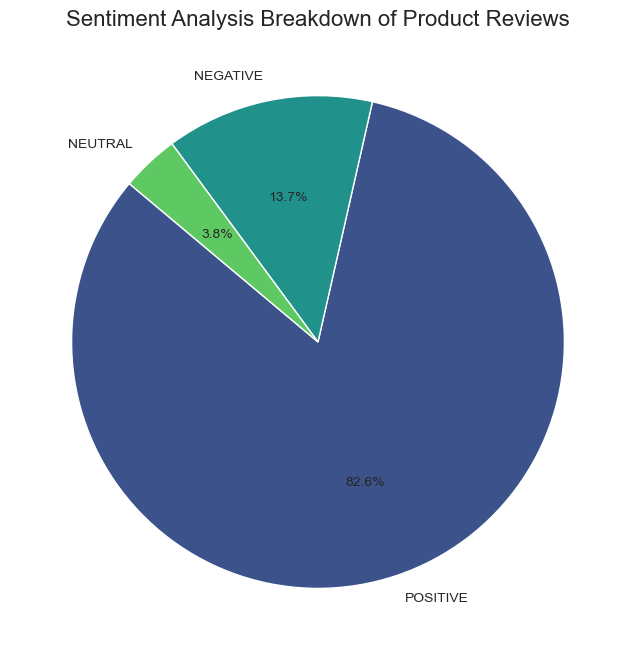


--- Summary ---
Total Reviews Analyzed: 476

Sentiment Distribution:
sentiment_label
POSITIVE    393
NEGATIVE     65
NEUTRAL      18
Name: count, dtype: int64

----------------------------------
Top 10 Keywords in POSITIVE Reviews:
good , nice , product , good product , nice product , quality , super , best , good quality , amazing

Top 10 Keywords in NEGATIVE Reviews:
bad , product , working , quality , bad product , worst , money , bad quality , don , worst product
----------------------------------


In [8]:
# --- Step 6: Generate the Summary Dashboard ---

# 1. Calculate sentiment counts
sentiment_counts = df['sentiment_label'].value_counts()

# 2. Create the Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(sentiment_counts)))
plt.title('Sentiment Analysis Breakdown of Product Reviews', fontsize=16)
plt.ylabel('') # Hides the 'sentiment_label' text on the y-axis
plt.show()

# 3. Display the Top Keywords
print("\n--- Summary ---")
print(f"Total Reviews Analyzed: {len(df)}")
print("\nSentiment Distribution:")
print(sentiment_counts)
print("\n----------------------------------")
print("Top 10 Keywords in POSITIVE Reviews:")
print(" , ".join(top_positive_keywords))
print("\nTop 10 Keywords in NEGATIVE Reviews:")
print(" , ".join(top_negative_keywords))
print("----------------------------------")